In [1]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

folder_path = '../experiment_data/tk_11092023'

exp_layout = {0:(0,['B','C','D']),
              10**-2:(0,['E','F','G']),
              10**-1:(1,['B','C','D']),
              10**0:(1,['E','F','G']),
              10**1:(2,['B','C','D']),
              10**2:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [2]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [3]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

# save as pickle

with open('data_11092023.pickle','wb') as f:
    pickle.dump(dict_t,f)

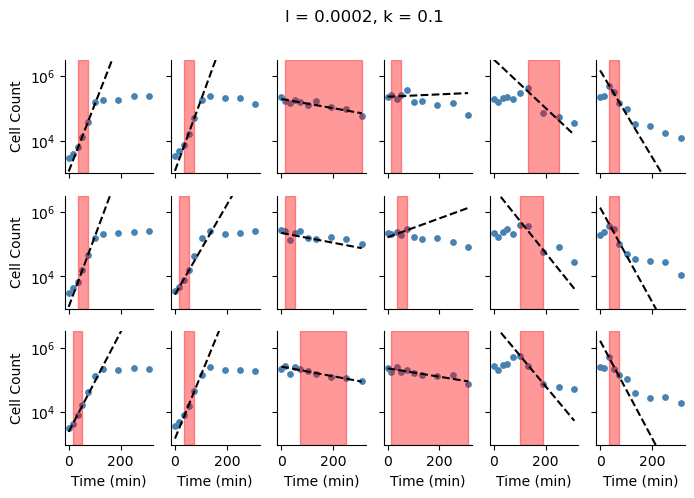

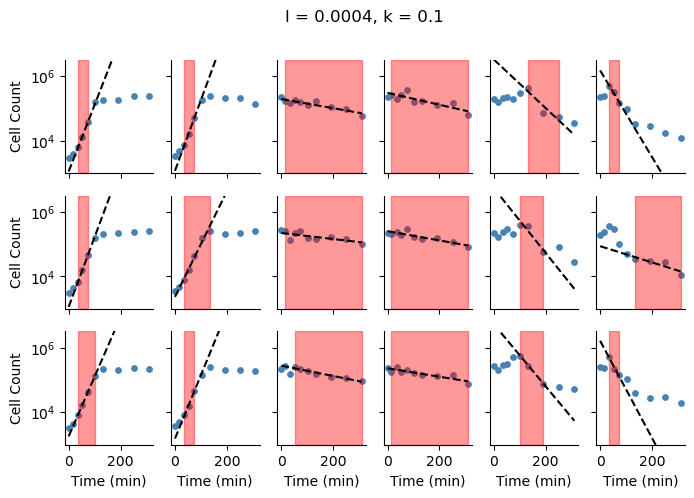

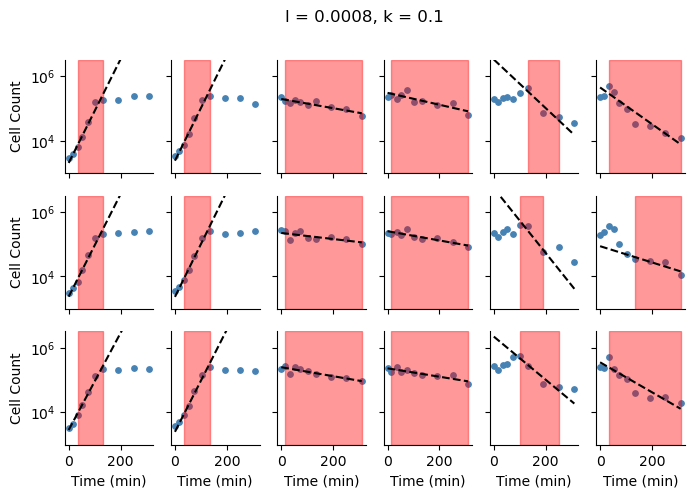

In [4]:
n_replicates = 3
n_conditions = len(cell_count_mean.keys())

exclude = 1

for l in [0.0002,0.0004,0.0008]:
    for k in [0.1]:

        fig,ax_list = plt.subplots(nrows=n_replicates,ncols=n_conditions,figsize=(8,5),sharex=True,sharey=True)

        time_fit = np.linspace(0,np.max(time),100)

        gr_dict = {}

        conc_list = []

        row_indx = 0
        for key in cell_count_mean.keys():

            slope_est = []
            

            for i in range(n_replicates):
                cell_count_t = cell_count_raw[key][i]

                ax = ax_list[i,row_indx]
                ax.scatter(time,cell_count_t,color='steelblue',alpha=1,s=15)

                if key > 1:
                    exclude = np.argwhere(cell_count_t == np.max(cell_count_t))[0][0]
                else:
                    exclude = 1

                cell_count_t = cell_count_t[exclude:]
                time_t = time[exclude:]

                if cell_count_t[-1] > cell_count_t[0]:
                    # start_indx = 0
                    # end_indx = np.argwhere(cell_count_t >= 0.7*cell_count_t[-1])[0][0]
                    slope_lb = 0.01
                    slope_ub = np.inf
                else:
                    slope_ub = 0
                    slope_lb = -np.inf

                # X = time_t[start_indx:end_indx]
                # Y = cell_count_t[start_indx:end_indx]
                X = time_t
                Y = cell_count_t
                lin_range = opt_linear_range(X,np.log10(Y),l,k,slope_ub=slope_ub,slope_lb=slope_lb)

                # ax.axvspan(time_t[start_indx],time_t[end_indx],color='gray',alpha=0.4)
                ax.axvspan(time_t[lin_range[0]],time_t[lin_range[1]],color='red',alpha=0.4)
                
                X_t = time_t[lin_range[0]:lin_range[1]+1]
                Y_t = cell_count_t[lin_range[0]:lin_range[1]+1]

                res = stats.linregress(X_t,np.log10(Y_t))

                # plot the regression
                X_fit = np.linspace(np.min(time),np.max(time),100)
                Y_fit = 10**(res.slope*X_fit + res.intercept)

                ax.plot(X_fit,Y_fit,color='k',linestyle='--')


                
            ax.set_yscale('log')

            row_indx += 1

        for ax in ax_list.flatten():
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yscale('log')
            ax.set_ylim(10**3,10**6.5)

        # for ax in ax_list[:,0:2].flatten():
        #     ax.set_ylim(10**3,10**6)

        # for ax in ax_list[:,2:].flatten():
        #     ax.set_ylim(10**4,10**6)


        for ax in ax_list[:,0]:
            ax.set_ylabel('Cell Count')

        for ax in ax_list[-1,:]:
            ax.set_xlabel('Time (min)')

        fig.suptitle('l = ' + str(l) + ', k = ' + str(k))

# fig.savefig('../../figures/raw_data_with_fit.pdf',bbox_inches='tight')
